# Project Summary
Train model to predict sentiment analysis. This model will the be used to predict Tweets that reference one of the top 5 banks in South Africa. 

Training: I used mutiple datasets to do this with Sentiment 140 being the creates contributor of tweets (1.6 million) 
However this was automatically labled (using emoticons) and doesnt have neutral tweets labled 

**Note** Proof of concept version was completed using a [pretrained model](https://www.kaggle.com/slythe/sentiment-analysis-with-twint-textblob-poc) (Textblob) 

## Datasets used
1. [Sentiment140](https://www.kaggle.com/milobele/sentiment140-dataset-1600000-tweets)
1. [Twitter and Reddit](https://www.kaggle.com/cosmos98/twitter-and-reddit-sentimental-analysis-dataset) 
1. [US airlines](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) 
1.[Apple sentiment](https://www.kaggle.com/slythe/apple-twitter-sentiment-crowdflower) 

## Known issues with sentiment analysis:
* Sarcasm - "thanks FNB, now I cant open my account cause its frozen" 
* Comparison of entities  - "Capitec is the worst, you should use Standard Bank" 
* Training data on non-South African tweets  - Jargon and lingo is different
* Language usage - multiple languages are used in South Africa

Reference notebooks:
* [Full sentiment analysis](https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis/notebook) 
* [beginners notebook](https://www.kaggle.com/stoicstatic/twitter-sentiment-analysis-for-beginners)

In [1]:
from IPython.display import Image
Image(url = "https://storage.ning.com/topology/rest/1.0/file/get/3780584426?profile=original",width = 1000, height=800)

In [49]:
import re
import string 
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import scipy.sparse

#preprocessing and scoring
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, recall_score, precision_score
from nltk.stem import WordNetLemmatizer 

#models and algos
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

##customer pipeline function
from sklearn.base import BaseEstimator, TransformerMixin

#Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

#Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold

In [3]:
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Note on stopwords
Removal of stop words seems to do more harm than good, many of the sentences lose their meaning. "not" and "nor" are particularly an issue as well as many of the prepositions \ 

**ie.**
> what is Apple doing, they won't do well  -->>  Apple well \
> I'm against Samsung  -->>  Samsung

## Read and setup datasets

In [4]:
train = pd.read_csv("./input/training.1600000.processed.noemoticon.csv",encoding="Latin-1" ,names=["polarity","id", "date","query", "user", "tweet"])
sentiment140  = pd.read_csv("./input/testdata.manual.2009.06.14.csv",encoding="Latin-1" ,names=["polarity","id", "date","query", "user", "tweet"])
apple = pd.read_csv("./input/Apple-Twitter-Sentiment-DFE.csv", encoding="Latin-1")
twitter_reddit = pd.read_csv("./input/Twitter_Data.csv")
us_airlines =  pd.read_csv("./input/Tweets.csv")

In [5]:
#remove unnecessary columns
train = train[["polarity", "tweet"]]
sentiment140 = sentiment140[["polarity", "tweet"]]
apple = apple[["sentiment","text"]]
us_airlines = us_airlines[["airline_sentiment", "text"]]
twitter_reddit = twitter_reddit[["category", "clean_text"]]

In [6]:
#rename columns
apple.columns = ["polarity","tweet"]
sentiment140.columns = ["polarity","tweet"]
us_airlines.columns = ["polarity","tweet"]
twitter_reddit.columns = ["polarity","tweet"]

In [7]:
#Replace values to have -1 negative, 0 neutral, 1 postive
train["polarity"]  = train["polarity"].replace(4,1)
train["polarity"]  = train["polarity"].replace(0,-1)

sentiment140["polarity"]  = sentiment140["polarity"].replace(4,1)
sentiment140["polarity"]  = sentiment140["polarity"].replace(0,-1)
sentiment140["polarity"]  = sentiment140["polarity"].replace(2,0)

apple["polarity"] = apple["polarity"].replace("1",-1)
apple["polarity"] = apple["polarity"].replace("3",0)
apple["polarity"] = apple["polarity"].replace("5",1)

us_airlines["polarity"] =us_airlines["polarity"].replace("negative",-1)
us_airlines["polarity"] =us_airlines["polarity"].replace("neutral",0)
us_airlines["polarity"] =us_airlines["polarity"].replace("positive",1)

In [8]:
apple = apple[apple["polarity"]!= "not_relevant"]
apple["polarity"] = apple["polarity"].astype(int) 

In [9]:
twitter_reddit.dropna(inplace= True)

In [10]:
print("train: ", len(train))
print("sentiment140: ", len(sentiment140))
print("apple: ", len(apple))
print("twitter_reddit: ", len(twitter_reddit))
print("us_airlines: ", len(us_airlines))

train:  1600000
sentiment140:  498
apple:  3804
twitter_reddit:  162969
us_airlines:  14640


In [11]:
tweets_df = pd.concat([train,sentiment140,apple,us_airlines,twitter_reddit],axis=0)

<AxesSubplot:xlabel='polarity', ylabel='count'>

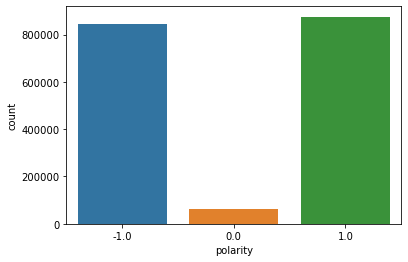

In [12]:
sns.countplot(data = tweets_df , x = "polarity")

Due to the sentiment140 training data not including neutral tweets we have a imbalanced dataset 

# Additional Features
There are a number of additional features that can be added however this can be its own notebook. We will look only at length for now

In [13]:
tweets_df["tweet"] = tweets_df["tweet"].astype(str)
tweets_df.reset_index(drop = True,inplace=True)

In [14]:
# Length  
tweets_df["length"] = tweets_df["tweet"].apply(len)

In [15]:
tweets_df.groupby("polarity")["length"].describe()

,count,mean,std,min,25%,50%,75%,max
polarity,,,,,,,,
-1.0,846083.0,77.853270,41.165913,5.0,45.0,72.0,109.0,359.0
0.0,60611.0,88.818036,55.568413,1.0,47.0,75.0,120.0,267.0
1.0,875217.0,79.383835,43.483240,4.0,45.0,72.0,109.0,374.0


<Figure size 1080x360 with 0 Axes>

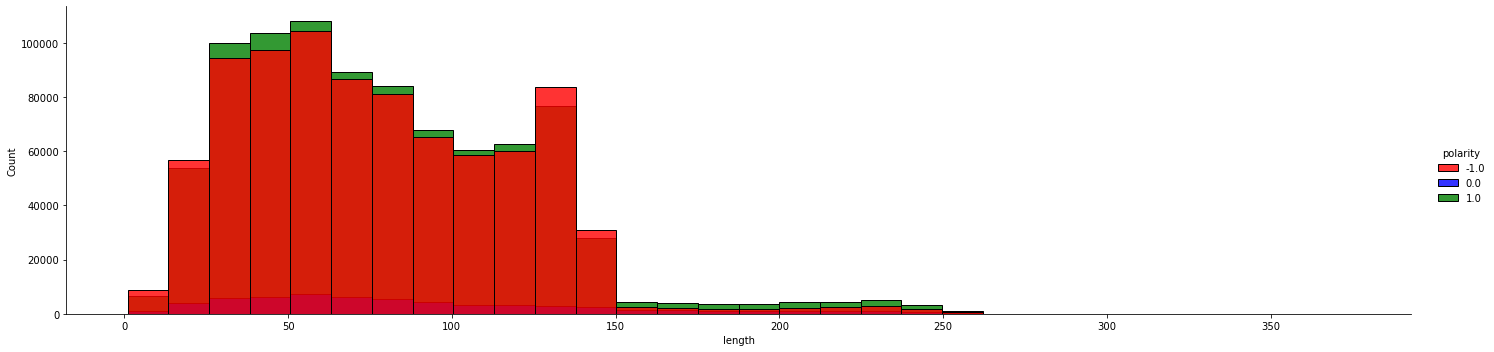

In [16]:
plt.figure(figsize=(15,5))

sns.displot(data = tweets_df, x= "length", hue= "polarity" ,palette={-1:"r",0:"b",1:"g"}, bins = 30,aspect= 4, alpha = 0.8)

# Cleaning 

In [17]:
def clean_text(text):  
    pat1 = r'@[^ ]+'                   #@signs and value
    pat2 = r'https?://[A-Za-z0-9./]+'  #links
    pat3 = r'\'s'                      #floating s's
    pat4 = r'\#\w+'                     # hashtags and value
    pat5 = r'&amp '
    pat6 = r'[^A-Za-z\s]'         #remove non-alphabet
    combined_pat = r'|'.join((pat1, pat2,pat3,pat4,pat5, pat6))
    text = re.sub(combined_pat,"",text).lower()
    return text.strip()

In [18]:
#clean
tweets_df["cleaned_tweet"] = tweets_df["tweet"].apply(clean_text)

In [19]:
#drop empty 
tweets_df = tweets_df [ ~(tweets_df["cleaned_tweet"] =="")]

### Lemmetization 

In [20]:
lem = WordNetLemmatizer()

def tokenize_lem(sentence):
    outlist= []
    token = sentence.split()
    for tok in token:
        outlist.append(lem.lemmatize(tok))
    return " ".join(outlist)

In [21]:
tweets_df["cleaned_tweet"] = tweets_df["cleaned_tweet"].apply(tokenize_lem)

In [22]:
tweets_df.head()

,polarity,tweet,length,cleaned_tweet
0,-1.0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115,awww that a bummer you shoulda got david carr ...
1,-1.0,is upset that he can't update his Facebook by ...,111,is upset that he cant update his facebook by t...
2,-1.0,@Kenichan I dived many times for the ball. Man...,89,i dived many time for the ball managed to save...
3,-1.0,my whole body feels itchy and like its on fire,47,my whole body feel itchy and like it on fire
4,-1.0,"@nationwideclass no, it's not behaving at all....",111,no it not behaving at all im mad why am i here...


In [23]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1777958 entries, 0 to 1781910
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   polarity       float64
 1   tweet          object 
 2   length         int64  
 3   cleaned_tweet  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 67.8+ MB


#### Split the data

In [24]:
X_train, X_test, y_train, y_test = train_test_split(tweets_df[["cleaned_tweet","length"]], tweets_df["polarity"], test_size=0.1, random_state=42)

### TF-IDF 
vectorise the tweets 

In [25]:
tfidf = TfidfVectorizer()

In [26]:
tfidf.fit(X_train["cleaned_tweet"])

TfidfVectorizer()

In [27]:
X_train_v = tfidf.transform(X_train["cleaned_tweet"])
X_test_v = tfidf.transform(X_test["cleaned_tweet"])

In [28]:
print(X_train_v.shape)
print(X_test_v.shape)

(1600162, 432733)
(177796, 432733)


#### Add TFIDF to tweets vector and Scaling

In [29]:
scaler = MinMaxScaler()
scaler2 = MinMaxScaler()

In [30]:
scaler.fit([X_train["length"]])
scaler2.fit([X_test["length"]])

MinMaxScaler()

In [31]:
X_train_len = scaler.transform([X_train["length"]])
X_train_len = X_train_len.reshape( X_train_v.shape[0], 1)

X_train = scipy.sparse.hstack([X_train_v,X_train_len], format = "csr")

In [32]:
X_test_len = scaler2.transform([X_test["length"]])
X_test_len = X_test_len.reshape(X_test_v.shape[0], 1)

X_test = scipy.sparse.hstack([X_test_v,X_test_len], format = "csr")

In [33]:
"""MinMaxScaler = scaler.fit_transform([tweets_df["length"]])
MinMaxScaler = MinMaxScaler.reshape( tweets_v.shape[0], 1)
tweets_v_scaled = scipy.sparse.hstack([tweets_v,MinMaxScaler], format = "csr")"""

'MinMaxScaler = scaler.fit_transform([tweets_df["length"]])\nMinMaxScaler = MinMaxScaler.reshape( tweets_v.shape[0], 1)\ntweets_v_scaled = scipy.sparse.hstack([tweets_v,MinMaxScaler], format = "csr")'

### Algorithms used:
* Random Forest
* LinearSVC
* Naive Bayes (Bernoulini and Multinomial)
* XGBoost
* Logistic Regression
* Ridge 

### Out-the-box models for comparison:
1. Textblob 
1. Vader

## GridSearchCV
Due to the time some of these models took to run, the tuning for the below models were was done outside Kaggle and as a result some parameter iterations were reduced:

#### params per model
* LogisticRegression(C=5, max_iter=10000, solver='sag')
* LinearSVC(C=1)
* RidgeClassifier(alpha=3)
* BernoulliNB(alpha=1)
* MultinomialNB(alpha=0.01)
* XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, eta=0.5, gamma=0,\n gpu_id=-1, importance_type='gain', interaction_constraints='',\n learning_rate=0.5, max_delta_step=0, max_depth=9,\n min_child_weight=1, missing=nan, monotone_constraints='()',\n n_estimators=500, n_jobs=4, num_parallel_tree=1,\n objective='multi:softprob', random_state=0, reg_alpha=0,\n reg_lambda=1, scale_pos_weight=None, subsample=1,\n tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
#Parameters tested outside Kaggle 
'''gen_params = {"alpha":[0.001,0.01,1,3,4,5]}

xgb_params={'eta': [0.5, 1, 2, 3], 
            'max_depth': [None, 3, 5, 7, 9],
                         
            'n_estimators': [50, 100, 150, 200, 300, 500]
           }
lnSVC_params = {
    "C": [0.01,1,3,4,5,10]
}
logr_params = {
    "penalty": ["l2" ,"l1", "none"],
    "C": [1,3,4,5],
    "max_iter": [5000,10000]
}

forest_params = {"n_estimators": [50, 100],
                 "max_depth" : [1,5, 10]
}'''

'gen_params = {"alpha":[0.001,0.01,1,3,4,5]}\n\nxgb_params={\'eta\': [0.5, 1, 2, 3], \n            \'max_depth\': [None, 3, 5, 7, 9],\n                         \n            \'n_estimators\': [50, 100, 150, 200, 300, 500]\n           }\nlnSVC_params = {\n    "C": [0.01,1,3,4,5,10]\n}\nlogr_params = {\n    "penalty": ["l2" ,"l1", "none"],\n    "C": [1,3,4,5],\n    "max_iter": [5000,10000]\n}\n\nforest_params = {"n_estimators": [50, 100],\n                 "max_depth" : [1,5, 10]\n}'

In [35]:
kfold =StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

In [36]:
model_score = pd.DataFrame(columns=["model_f1_train","params_used", "f1","precision","recall"])


def model_prediction(model, params):
    
    model = GridSearchCV(model, param_grid= params, cv= kfold)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print ("Model and params: ", model.best_estimator_, model.best_params_) 
    print("\n")
    print("Train score: ", model.best_score_)
    print("test score: ",accuracy_score(y_test,y_pred))
    print("\n")
    print("Test Report:")
    print(classification_report(y_test,y_pred))
    return y_pred, model

In [37]:
def model_scoring(y_pred, model):
    global y_test
    global model_score
    
    df = pd.DataFrame(data = [[model.best_score_,
                           model.best_params_,
                           f1_score(y_test,y_pred,average="macro"),
                           precision_score(y_test,y_pred,average="macro"),
                           recall_score(y_test,y_pred,average="macro")
                          ]] , 
                  columns =model_score.columns, 
                  index=[str(model.best_estimator_)])
    model_score = model_score.append ( df )  

In [38]:
#Set Parameters
gen_params = {"alpha":[1,3]}
xgb_params = {
        'n_estimators': [200],
        'max_depth': [9],
        'eta': [0.5],
}
lnSVC_params = {
    "C": [1]
}
logr_params = {
    "penalty": ["l2"],
    "C": [5],
    "max_iter": [10000]
}
forest_params = {"n_estimators": [100],
                 "max_depth" : [8]
}

### Run GridSearchCV

In [39]:
#Instantiate
vader = SentimentIntensityAnalyzer()
#textblob does not required instantiation 

logr_i = LogisticRegression(solver="sag")
ridge_i = RidgeClassifier()                 # L2 regularization
lnSVC_i = LinearSVC()
naivemulti_i = MultinomialNB()
naivebern_i = BernoulliNB()
xgb_i = XGBClassifier(#tree_method='gpu_hist'
                     )
rf_i = RandomForestClassifier()

In [40]:
log_pred , logr_m = model_prediction(logr_i,logr_params)
ridge_pred, ridge_m = model_prediction(ridge_i,{"alpha":[3]})
linSVC_pred, lnSVC_m = model_prediction(lnSVC_i, lnSVC_params)
naivemulti_pred, naivemulti_m = model_prediction(naivemulti_i, gen_params)
naivebern_pred, naivebern_m = model_prediction(naivebern_i, gen_params)
xgb_pred, xgb_m = model_prediction(xgb_i, xgb_params)
rf_pred, rf_m = model_prediction(rf_i,forest_params)

Model and params:  LogisticRegression(C=5, max_iter=10000, solver='sag') {'C': 5, 'max_iter': 10000, 'penalty': 'l2'}


Train score:  0.7864228746576617
test score:  0.7871324439244978


Test Report:
              precision    recall  f1-score   support

        -1.0       0.79      0.77      0.78     84112
         0.0       0.84      0.78      0.81      6227
         1.0       0.78      0.80      0.79     87457

    accuracy                           0.79    177796
   macro avg       0.80      0.78      0.79    177796
weighted avg       0.79      0.79      0.79    177796

Model and params:  RidgeClassifier(alpha=3) {'alpha': 3}


Train score:  0.7749534114364387
test score:  0.7763560485050283


Test Report:
              precision    recall  f1-score   support

        -1.0       0.79      0.77      0.78     84112
         0.0       0.68      0.45      0.54      6227
         1.0       0.77      0.80      0.79     87457

    accuracy                           0.78    177796
   macro

C:\Users\andre\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:22:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:22:54] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:55] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:20:31] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

C:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        -1.0       0.87      0.16      0.28     84112
         0.0       0.00      0.00      0.00      6227
         1.0       0.53      0.98      0.68     87457

    accuracy                           0.56    177796
   macro avg       0.47      0.38      0.32    177796
weighted avg       0.67      0.56      0.47    177796



In [57]:
model_scoring(log_pred, logr_m)
model_scoring(ridge_pred, ridge_m)
model_scoring(linSVC_pred, lnSVC_m)
model_scoring(naivemulti_pred, naivemulti_m)
model_scoring(naivebern_pred, naivebern_m)
model_scoring(xgb_pred, xgb_m)
model_scoring(rf_pred, rf_m)

ValueError: Found input variables with inconsistent numbers of samples: [533388, 177796]

In [42]:
model_score

,model_f1_train,params_used,f1,precision,recall
"LogisticRegression(C=5, max_iter=10000, solver='sag')",0.786423,"{'C': 5, 'max_iter': 10000, 'penalty': 'l2'}",0.793341,0.802866,0.784613
RidgeClassifier(alpha=3),0.774953,{'alpha': 3},0.701908,0.746598,0.673970
LinearSVC(C=1),0.783292,{'C': 1},0.780187,0.797435,0.765312
MultinomialNB(alpha=3),0.745198,{'alpha': 3},0.506943,0.830172,0.515313
BernoulliNB(alpha=3),0.746686,{'alpha': 3},0.560797,0.608912,0.548963


# Out-the box models

In [43]:
def out_box_textblob(x):
    x = TextBlob(x).sentiment[0]
    if x >0:
        x = 1
    elif x<0:
        x = -1
    else:
        x= 0
    return x

In [44]:
def out_box_vader(x):
    x = vader.polarity_scores(x)["compound"]
    if x >0:
        x = 1
    elif x<0:
        x = -1
    else:
        x= 0
    return x

In [45]:
def out_box_score(y_true, prediction):
    global model_score
    df = pd.DataFrame(data = [[0,
                               0,
                               f1_score(y_true,prediction,average="macro"),
                               precision_score(y_true,prediction,average="macro"),
                               recall_score(y_true,prediction,average="macro")
                              ]] ,
                      columns=model_score.columns, 
                      index=[str(prediction.name)])
    model_score = model_score.append ( df )

In [46]:
textblob_pred = tweets_df["cleaned_tweet"].apply(out_box_textblob)
vader_pred = tweets_df["cleaned_tweet"].apply(out_box_vader)

out_box_score(tweets_df["polarity"],vader_pred)
out_box_score(tweets_df["polarity"],textblob_pred)

In [ ]:
model_score

## Save all models & vocab

In [50]:
model_dict = {
    logr_m : "logr_m",
    ridge_m:"ridge_m",lnSVC_m:"lnSVC_m", naivemulti_m:"naivemulti_m", naivebern_m:"naivebern_m",xgb_m:"xgb_m"
              ,rf_m: "rf_m"
             }
for m in model_dict.items():
    file = open(f'{m[1]}.pickle','wb')
    pickle.dump(m[0], file)
    file.close()

In [51]:
## save vocabulary 
with open("vocabulary","wb") as f:
    pickle.dump(tfidf.vocabulary_,f)
    f.close()

## Voting Classifier 
Option ensemble 

In [ ]:
"""from sklearn.ensemble import VotingClassifier
vc = VotingClassifier([("logr_m",LogisticRegression()), 
                       ("ridge_m",RidgeClassifier()), 
                       ("lnSVC_m",LinearSVC()), 
                       ("ridge_m",ridge_m),
                       ("naivemulti_m",MultinomialNB()),
                       ("rf_m",RandomForestClassifier(),
                       ("xgb_m",XGBClassifier()
                       ))],
                      voting = "hard")
vc.fit(X_train, y_train)"""

# Pipeline

In [52]:
from sklearn.pipeline import Pipeline

X = tweets_df["cleaned_tweet"]
y = tweets_df["polarity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [53]:
pipe = Pipeline(steps = [
    ("tfidf", TfidfVectorizer()),
    ("xgb" , GridSearchCV(xgb_i, param_grid= xgb_params, cv= kfold))
]
               )

In [54]:
pipe.fit(X,y)

C:\Users\andre\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:53:31] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:11:47] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:34:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:12:28] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('xgb',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                              estimator=XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
      

In [55]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

        -1.0       0.83      0.78      0.81    252947
         0.0       0.88      0.84      0.86     18298
         1.0       0.80      0.85      0.82    262143

    accuracy                           0.82    533388
   macro avg       0.84      0.82      0.83    533388
weighted avg       0.82      0.82      0.82    533388



## Save pipeline

In [56]:
file = open('pipemodel_model.pickle','wb')
pickle.dump(pipe, file)
file.close()